# Training of agents

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Load game and gym
from src.Dice421.Game import Dice421Env
import gymnasium as gym
from src.Dice421.logger import clear_log

# Load agents
from src.Agents.RandomAgent import RandomPlayer
from src.Agents.ManualAgent import ManualPlayer
from src.Agents.NNAgent import NNPlayer
from tqdm import tqdm

In [4]:
# Training loop number
n_episodes = 20_000
env = gym.make("Dice421-v0", seed=1234)
env2 = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)

First we train the agent against an agent playing randomly.

In [5]:
# hyperparameters
learning_rate = 0.01
start_epsilon = 1.0
epsilon_decay = start_epsilon / (n_episodes / 2)  # reduce the exploration over time
final_epsilon = 0.1

agent_NN_1 = NNPlayer(
    env=env2,
    learning_rate=learning_rate,
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
    name="NN",
)

outputs_train_NN_Random = [None for x in range(n_episodes)]
for i, episode in tqdm(enumerate(range(n_episodes))):
    outputs_train_NN_Random[i] = env2.run(agent_NN_1, RandomPlayer(env=env2, name="South"), render=False)
    agent_NN_1.decay_epsilon()

0it [00:00, ?it/s]

/home/nchagnet/pyenvs/game-ai-421-dice_py/lib/python3.11/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.run to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.run` for environment variables or `env.get_wrapper_attr('run')` that will search the reminding wrappers.
  logger.warn(
20000it [04:57, 67.30it/s] 


We then copy this agent and train the copy against the original.

In [6]:
agent_NN_2 = NNPlayer(
    env=env2,
    learning_rate=learning_rate,
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
    name="NN2",
)
agent_NN_2.q_values = agent_NN_1.q_values.copy()

outputs_train_NN_NN = [None for x in range(n_episodes)]
for i, episode in tqdm(enumerate(range(n_episodes))):
    outputs_train_NN_NN[i] = env2.run(agent_NN_1, agent_NN_2, render=False, player1_learn=False)
    agent_NN_2.decay_epsilon()

0it [00:00, ?it/s]/home/nchagnet/pyenvs/game-ai-421-dice_py/lib/python3.11/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.run to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.run` for environment variables or `env.get_wrapper_attr('run')` that will search the reminding wrappers.
  logger.warn(
20000it [03:50, 86.63it/s] 


## Checks

Now we can check the performance of our agents by making them play against each other many times.

In [7]:
n_checks = 4_000
outputs_checks_1 = [None for x in range(n_checks)]
for episode in tqdm(range(n_checks)):
    outputs_checks_1[episode] = env2.run(
        RandomPlayer(env2, name="North"),
        RandomPlayer(env=env2, name="South"),
        render=False,
        player1_learn=False,
        player2_learn=False,
    )

outputs_checks_2 = [None for x in range(n_checks)]
for episode in tqdm(range(n_checks)):
    outputs_checks_2[episode] = env2.run(
        agent_NN_1,
        RandomPlayer(env=env2, name="South"),
        render=False,
        player1_learn=False,
        player2_learn=False,
    )

outputs_checks_3 = [None for x in range(n_checks)]
for episode in tqdm(range(n_checks)):
    outputs_checks_3[episode] = env2.run(
        agent_NN_2,
        RandomPlayer(env=env2, name="South"),
        render=False,
        player1_learn=False,
        player2_learn=False,
    )

outputs_checks_4 = [None for x in range(n_checks)]
for episode in tqdm(range(n_checks)):
    outputs_checks_4[episode] = env2.run(
        agent_NN_1,
        agent_NN_2,
        render=False,
        player1_learn=False,
        player2_learn=False,
    )

100%|██████████| 4000/4000 [00:24<00:00, 165.86it/s]


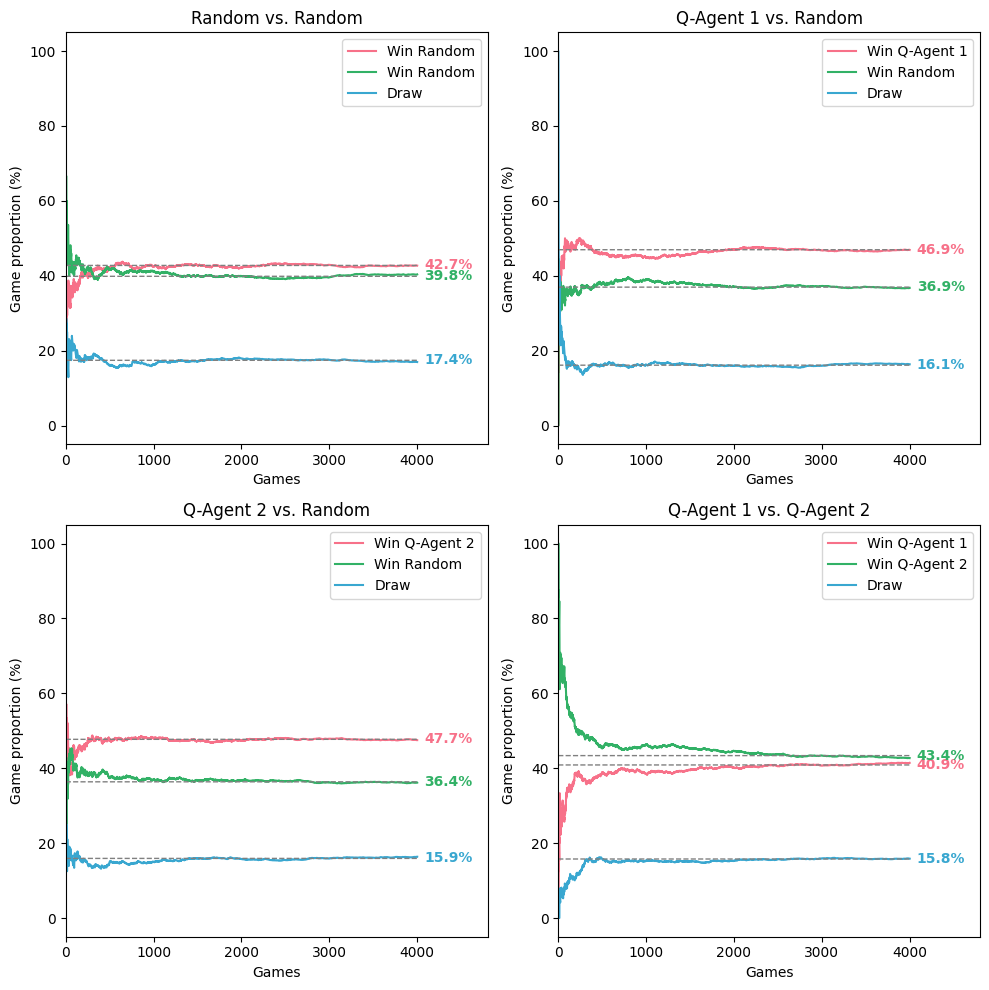

In [10]:
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(10, 10))
X = np.arange(1, n_checks + 1)


def plot_check(output, ax, names):
    colors = ["#f77189", "#32b166", "#39a7d0"]
    # Ticks
    ax.set_xlabel("Games")
    ax.set_ylabel("Game proportion (%)")
    ax.set_title(f"{names[0]} vs. {names[1]}")
    ax.set_xlim(0, X[-1] * 1.2)

    # Lines
    y1 = 100 * np.array([x["winner"] == 0 for x in output]).cumsum() / X
    y2 = 100 * np.array([x["winner"] == 1 for x in output]).cumsum() / X
    y3 = 100 * np.array([x["winner"] == -1 for x in output]).cumsum() / X
    m1 = ax.plot(X, y1, label=f"Win {names[0]}", color=colors[0])
    m2 = ax.plot(X, y2, label=f"Win {names[1]}", color=colors[1])
    m3 = ax.plot(X, y3, label=f"Draw", color=colors[2])

    # Means of last 100 points
    ym1 = y1[-2000:].mean()
    ym2 = y2[-2000:].mean()
    ym3 = y3[-2000:].mean()

    # Ticks and legend
    for i, val in enumerate([ym1, ym2, ym3]):
        ax.plot(
            X,
            val * np.ones(X.shape),
            linestyle="--",
            color="gray",
            linewidth=1,
        )
        ax.text(
            1.02 * X[-1],
            (1 + 0.0 * (-1) ** (i)) * val,
            f"{val:.1f}%",
            color=colors[i],
            fontweight="bold",
            horizontalalignment="left",
            verticalalignment="center",
        )
    ax.legend()


plot_check(outputs_checks_1, axs[0, 0], ["Random", "Random"])
plot_check(outputs_checks_2, axs[0, 1], ["Q-Agent 1", "Random"])
plot_check(outputs_checks_3, axs[1, 0], ["Q-Agent 2", "Random"])
plot_check(outputs_checks_4, axs[1, 1], ["Q-Agent 1", "Q-Agent 2"])
fig.tight_layout()
fig.savefig("figs/comparison_agents.png", dpi=300)